# Part 2 : Exploration + Data preprocessing

![title](logos/instructions.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import re
import platform
from datetime import datetime, timedelta

# Cleanup

## Booking cleanup
![title](logos/booking_logo.png)

In [2]:
# Load the data
dfs=[]
for file in ['booking_snap_1.csv','booking_snap_2.csv','booking_snap_3.csv', 'booking_snap_4.csv','booking_snap_5.csv']:
    current_df = pd.read_csv(file)
    dfs.append(current_df)

# Concatenate all dataframes in the list into a single dataframe
booking_df = pd.concat(dfs, ignore_index=True)

print(booking_df.shape)
booking_df.head(2)

(106820, 12)


,website,snapshot_number,snapshot_date,start_date_str,end_date_str,ttt,los,name,rating,price,reviews_amount,index_in_page
0,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Pod 51,7.8\nScored 7.8,₪ 632,"10,744 reviews",1
1,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Hyatt Place New York/Midtown-South,8.2\nScored 8.2,₪ 693,"3,209 reviews",2


In [3]:
def extract_numeric(value):
    if isinstance(value, str):
        num_str = re.sub(r'[^\d.]', '', value)
        return float(num_str) if '.' in num_str else int(num_str)
    return value

In [4]:
def is_weekend_between(start_date_str, end_date_str):
    # Parse the start and end dates
    start_date = datetime.strptime(start_date_str, '%d %B %Y' )
    end_date = datetime.strptime(end_date_str, '%d %B %Y')
    
    # Increment through each day between start and end
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() >= 5:  # 5 for Saturday, 6 for Sunday
            return True
        current_date += timedelta(days=1)
    
    return False

In [5]:
# Clean the 'rating', 'price', and 'reviews_amount' columns
booking_df['rating'] = booking_df['rating'].apply(lambda x: extract_numeric(x.split('\n')[1] if '\n' in x else x))
booking_df['price'] = booking_df['price'].apply(lambda x: extract_numeric(x))
booking_df['reviews_amount'] = booking_df['reviews_amount'].apply(lambda x: extract_numeric(x))

# add is weekend column
booking_df['weekend'] = booking_df.apply(lambda row: is_weekend_between(row['start_date_str'], row['end_date_str']), axis=1)
booking_df['weekend'] = booking_df['weekend'].astype('int64')
booking_df['ttt'] = booking_df['ttt'].astype('int64')
booking_df['los'] = booking_df['los'].astype('int64')
booking_df['rating_category'] = pd.cut(booking_df['rating'], bins=np.arange(0, 11, 1), right=False, labels=[f"{i}-{i+1}" for i in range(10)])
booking_df['avg_price_per_day'] = booking_df['price'] / booking_df['los']

booking_df.head()

,website,snapshot_number,snapshot_date,start_date_str,end_date_str,ttt,los,name,rating,price,reviews_amount,index_in_page,weekend,rating_category,avg_price_per_day
0,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Pod 51,7.8,632,10744,1,1,7-8,632.0
1,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Hyatt Place New York/Midtown-South,8.2,693,3209,2,1,8-9,693.0
2,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Hyatt Place New York City/Times Square,7.6,693,21747,3,1,7-8,693.0
3,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Hyatt Place NYC Chelsea,7.9,693,15066,4,1,7-8,693.0
4,Booking,1,11 May 2024,12 May 2024,13 May 2024,1,1,Tuscany by LuxUrban,7.4,569,2297,5,1,7-8,569.0


## Expedia Clean Up
![title](logos/expedia_logo.png)

In [6]:
def is_weekend_between(start_date_str, end_date_str):
    # Parse the start and end dates
 
    start_date = datetime.strptime(start_date_str, '%A, %B %d, %Y' )
    end_date = datetime.strptime(end_date_str,'%A, %B %d, %Y')

    # Increment through each day between start and end
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() >= 5:  # 5 for Saturday, 6 for Sunday
            return True
        current_date += timedelta(days=1)
    
    return False

In [7]:
# Load the data
dfs=[]
for file in ['expedia_snap_1.csv','expedia_snap_2.csv', 'expedia_snap_3.csv','expedia_snap_4.csv']:
    current_df = pd.read_csv(file)
    dfs.append(current_df)

# Concatenate all dataframes in the list into a single dataframe
expedia_df = pd.concat(dfs, ignore_index=True)
print(expedia_df.shape)
expedia_df.head(2)

(80208, 12)


,website,snapshot_number,snapshot_date,start_date_str,end_date_str,ttt,los,name,rating,price,reviews_amount,index_in_page
0,Expedia,1,11 May 2024,"Sunday, May 12, 2024","Monday, May 13, 2024",1,1,Courtyard New York Manhattan/Times Square West,9.0,$188 total,"1,003 reviews",1
1,Expedia,1,11 May 2024,"Sunday, May 12, 2024","Monday, May 13, 2024",1,1,Tru By Hilton Brooklyn,8.6,$220 total,69 reviews,2


In [8]:
expedia_df['price'] = expedia_df['price'].str.replace(r'[$, total]', '', regex=True).astype(float)

conversion_rate = 3.7
expedia_df['price'] = expedia_df['price'] * conversion_rate

# Cleaning the 'reviews_amount' column to remove 'reviews' and convert to integer
expedia_df['reviews_amount'] = expedia_df['reviews_amount'].str.replace('reviews', '', regex=True).str.replace(',', '').str.replace('external','').str.replace(' ','').str.replace('review', '').astype(int)

# add is weekend column
expedia_df['weekend'] = expedia_df.apply(lambda row: is_weekend_between(row['start_date_str'], row['end_date_str']), axis=1)
expedia_df['weekend'] = expedia_df['weekend'].astype('int64')
expedia_df['ttt'] = expedia_df['ttt'].astype('int64')
expedia_df['los'] = expedia_df['los'].astype('int64')
expedia_df['rating_category'] = pd.cut(expedia_df['rating'], bins=np.arange(0, 11, 1), right=False, labels=[f"{i}-{i+1}" for i in range(10)])
expedia_df['start_date_str'] = pd.to_datetime(expedia_df['start_date_str'], format="%A, %B %d, %Y").dt.strftime("%d %B %Y")
expedia_df['end_date_str'] = pd.to_datetime(expedia_df['end_date_str'], format="%A, %B %d, %Y").dt.strftime("%d %B %Y")
expedia_df['avg_price_per_day'] = expedia_df['price'] / expedia_df['los']


In [9]:
expedia_df.head()

,website,snapshot_number,snapshot_date,start_date_str,end_date_str,ttt,los,name,rating,price,reviews_amount,index_in_page,weekend,rating_category,avg_price_per_day
0,Expedia,1,11 May 2024,12 May 2024,13 May 2024,1,1,Courtyard New York Manhattan/Times Square West,9.0,695.6,1003,1,1,9-10,695.6
1,Expedia,1,11 May 2024,12 May 2024,13 May 2024,1,1,Tru By Hilton Brooklyn,8.6,814.0,69,2,1,8-9,814.0
2,Expedia,1,11 May 2024,12 May 2024,13 May 2024,1,1,Penny Williamsburg,9.6,876.9,445,3,1,9-10,876.9
3,Expedia,1,11 May 2024,12 May 2024,13 May 2024,1,1,"PUBLIC, an Ian Schrager hotel",8.2,984.2,2488,4,1,8-9,984.2
4,Expedia,1,11 May 2024,12 May 2024,13 May 2024,1,1,Moxy NYC Downtown,8.6,606.8,1004,5,1,8-9,606.8


In [10]:
final_df =  pd.concat([booking_df, expedia_df], ignore_index=True)

In [11]:
def remove_price_outliers(df):
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
    return df_filtered

In [12]:
print("df before IQR: "+ str(len(final_df)))
final_df = remove_price_outliers(final_df)
print("df after IQR: "+ str(len(final_df)))

df before IQR: 187028
df after IQR: 180304


## Visualizations

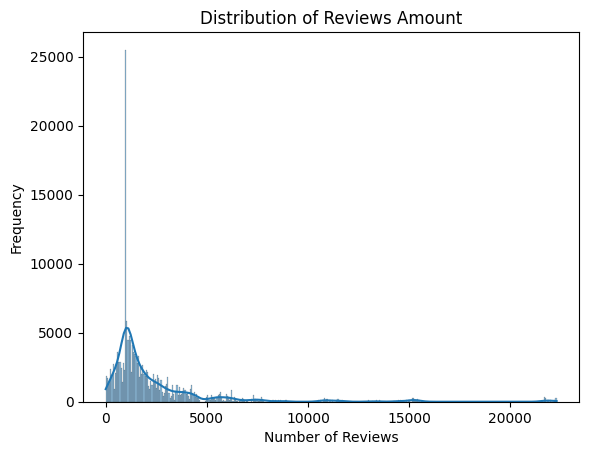

In [13]:
# Assuming data is your DataFrame
sns.histplot(data=final_df, x='reviews_amount', kde=True)
plt.title('Distribution of Reviews Amount')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

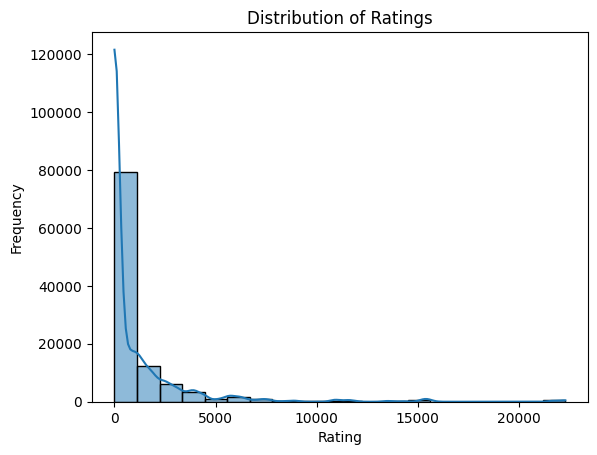

In [14]:
sns.histplot(data=booking_df, x='rating', bins=20, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

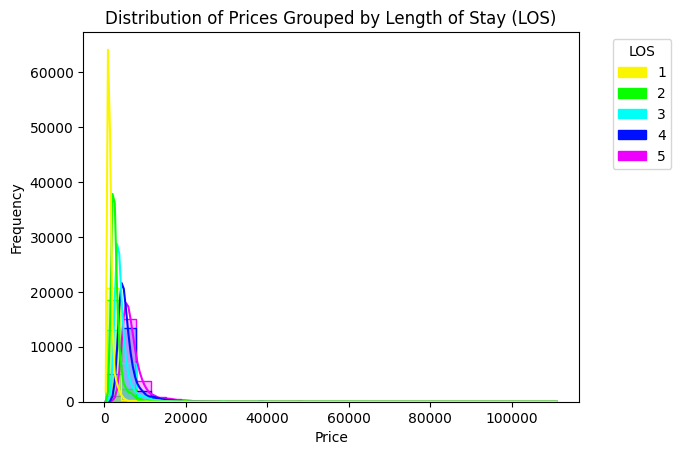

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # For custom legend handles

# Convert 'los' to string to ensure it is treated as a categorical variable
booking_df['los'] = booking_df['los'].astype(str)

# Generate a distinct color palette for each unique LOS value
palette = sns.color_palette("hsv", len(booking_df['los'].unique()))

# Create the histogram plot
fig, ax = plt.subplots()
sns.histplot(data=booking_df, x='price', hue='los', palette=palette, element='step', kde=True, bins=30, ax=ax)

# Set plot titles and labels
ax.set_title('Distribution of Prices Grouped by Length of Stay (LOS)')
ax.set_xlabel('Price')
ax.set_ylabel('Frequency')

# Create a custom legend
handles = [mpatches.Patch(color=palette[i], label=label) for i, label in enumerate(booking_df['los'].unique())]
ax.legend(handles=handles, title='LOS', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()


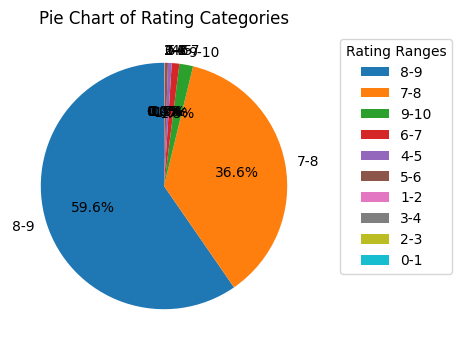

In [16]:
# Categorize ratings into bins from 0-1, 1-2, ..., 9-10
booking_df['rating_category'] = pd.cut(booking_df['rating'], bins=np.arange(0, 11, 1), right=False, labels=[f"{i}-{i+1}" for i in range(10)])

# Count the frequency of each category
rating_counts = booking_df['rating_category'].value_counts()

# Plot pie chart
plt.figure(figsize=(5, 4))
pie = plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie Chart of Rating Categories')
plt.legend(title='Rating Ranges', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

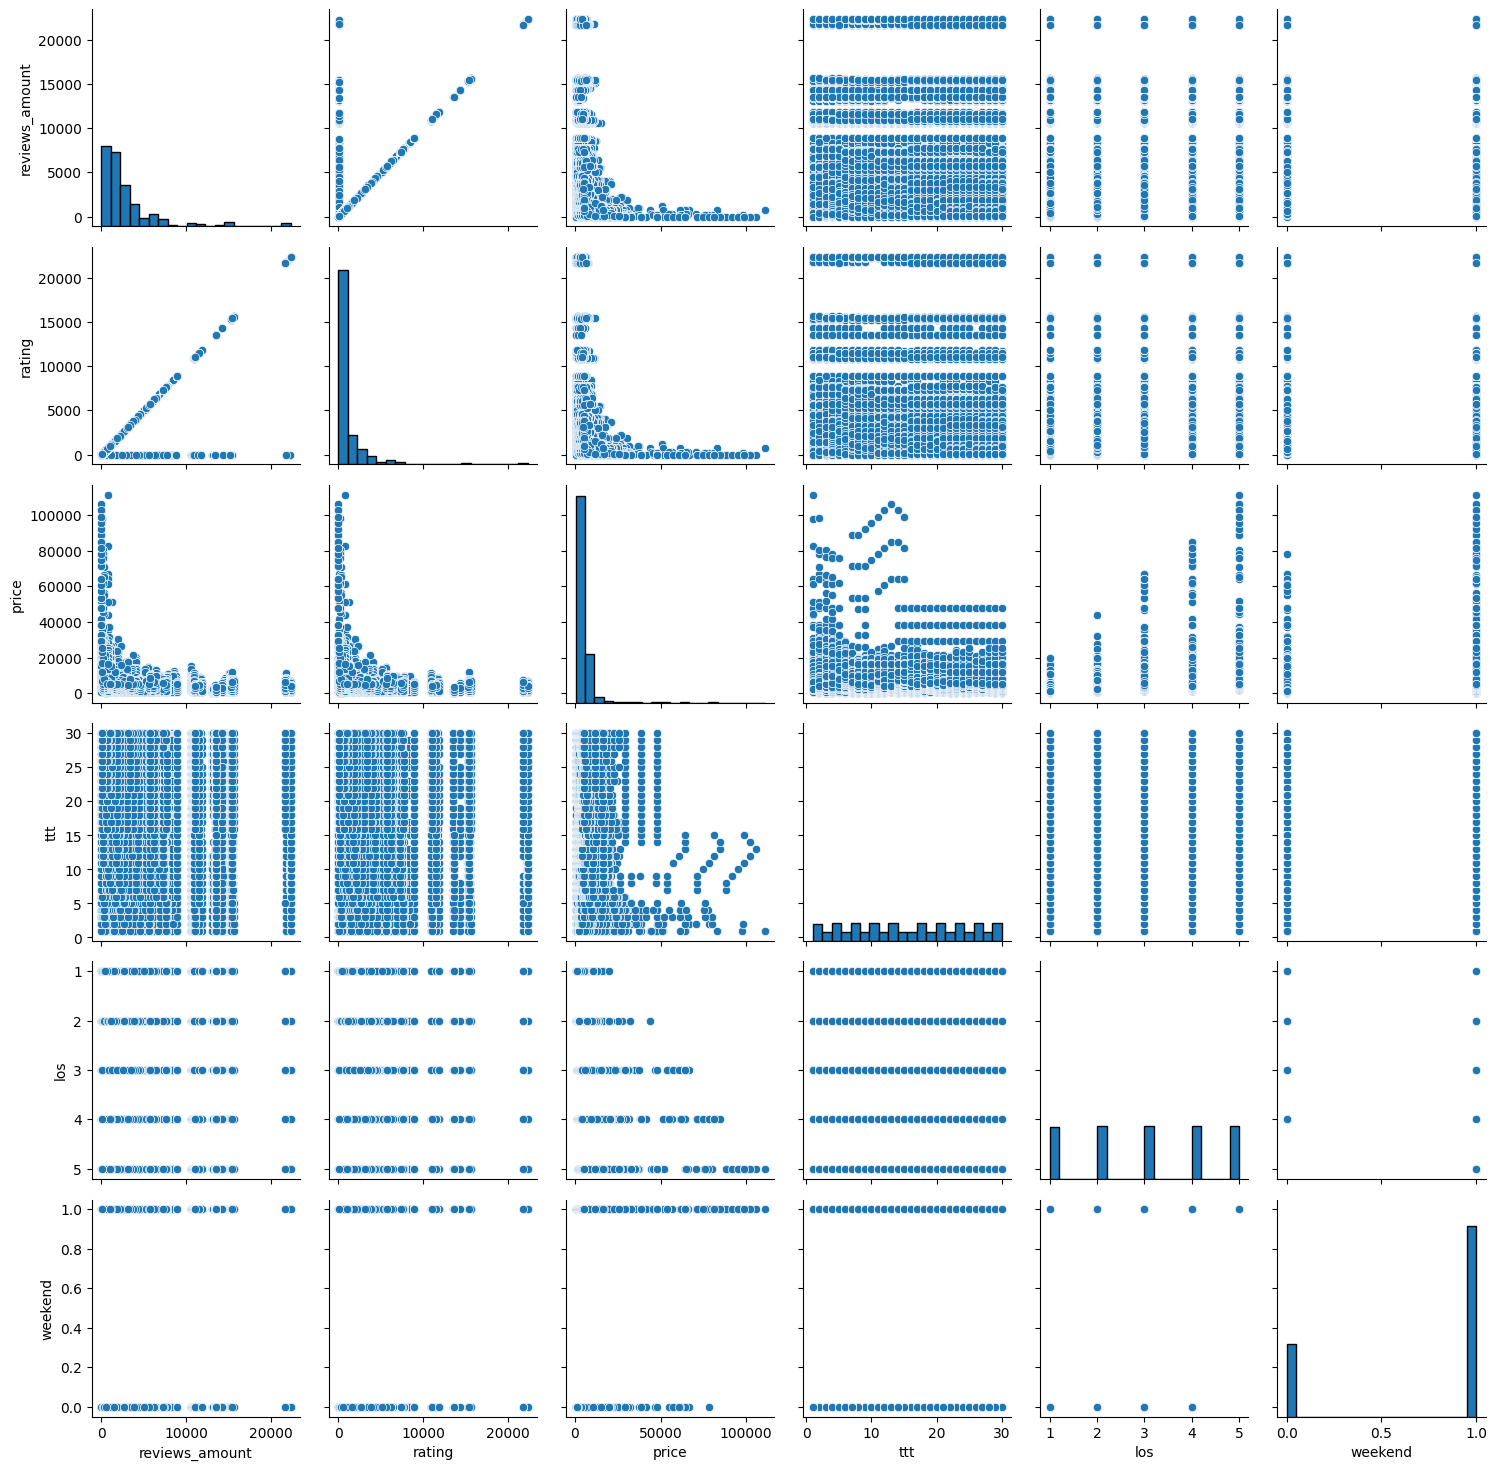

In [17]:
# Seaborn PairGrid for exploring relationships
pair_grid = sns.PairGrid(booking_df, vars=['reviews_amount', 'rating', 'price','ttt','los','weekend'])
pair_grid = pair_grid.map_diag(plt.hist, bins=20, edgecolor='k')
pair_grid = pair_grid.map_offdiag(sns.scatterplot)
plt.show()

In [18]:
## save

In [19]:
final_df.to_csv('final_csv.csv',index=False)

In [20]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 180304 entries, 0 to 187027
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   website            180304 non-null  object  
 1   snapshot_number    180304 non-null  int64   
 2   snapshot_date      180304 non-null  object  
 3   start_date_str     180304 non-null  object  
 4   end_date_str       180304 non-null  object  
 5   ttt                180304 non-null  int64   
 6   los                180304 non-null  int64   
 7   name               180304 non-null  object  
 8   rating             180304 non-null  float64 
 9   price              180304 non-null  float64 
 10  reviews_amount     180304 non-null  int64   
 11  index_in_page      180304 non-null  int64   
 12  weekend            180304 non-null  int64   
 13  rating_category    138910 non-null  category
 14  avg_price_per_day  180304 non-null  float64 
dtypes: category(1), float64(3), int64(6), o